## Libraries Importing

In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re

# PyTorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

print("Libraries imported successfully.")

Libraries imported successfully.


## Data Loading

In [2]:
# Cell 2: Load the Dataset
# ---
# In a Kaggle environment, the path to the dataset is typically fixed.
# You might need to adjust this path based on your specific Kaggle notebook setup.
# ---
file_path = '/kaggle/input/empathetic-dialogues-facebook-ai/emotion-emotion_69k.csv'

try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}")
    print("Please make sure the dataset is correctly linked to your Kaggle notebook.")

Dataset loaded successfully.


## Data Initializing

DataFrame successfully cleaned and restructured.

Cleaned DataFrame Head:
       emotion                                          Situation  \
0  sentimental  I remember going to the fireworks with my best...   
1  sentimental  I remember going to the fireworks with my best...   
2  sentimental  I remember going to the fireworks with my best...   
3  sentimental  I remember going to the fireworks with my best...   
4  sentimental  I remember going to the fireworks with my best...   

                                  customer_utterance  \
0  I remember going to see the fireworks with my ...   
1                This was a best friend. I miss her.   
2                                 We no longer talk.   
3  Was this a friend you were in love with, or ju...   
4                                Where has she gone?   

                                         agent_reply  
0  Was this a friend you were in love with, or ju...  
1                                Where has she gone?  
2  Oh was

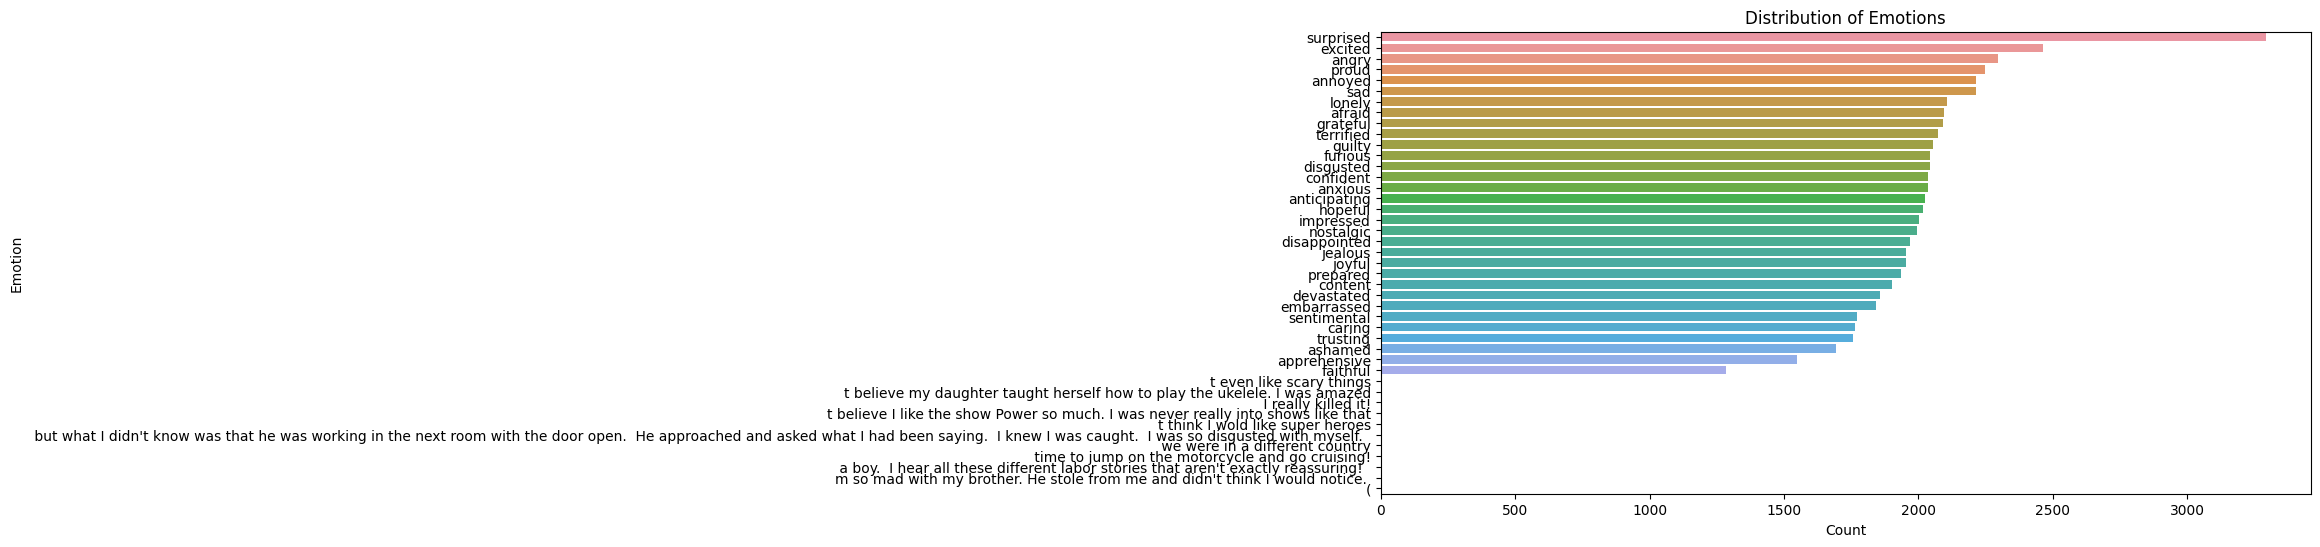

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


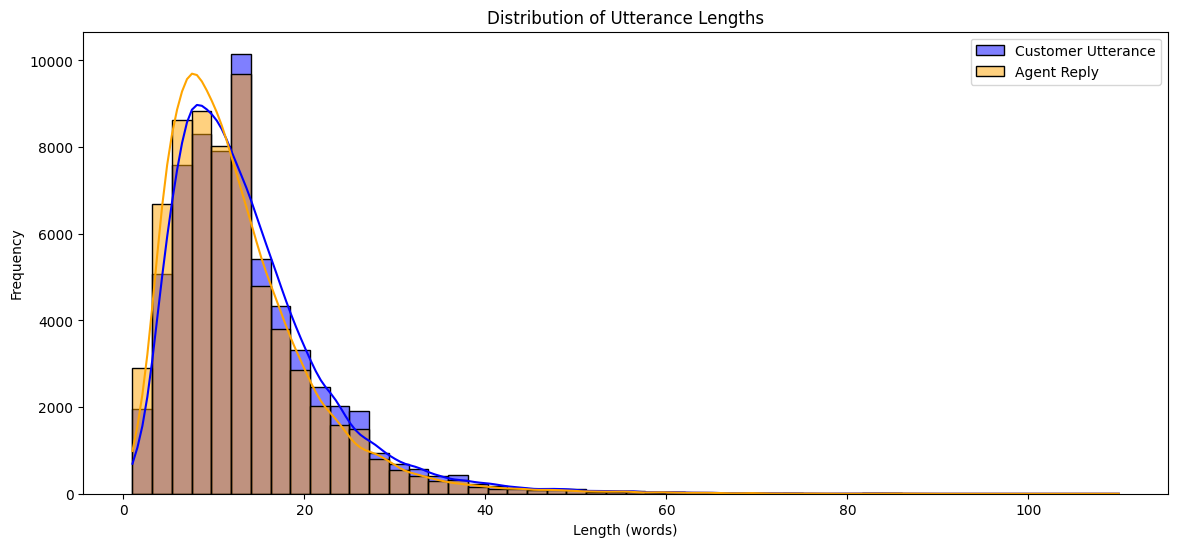

In [3]:
# Cell 3 : Clean and Restructure the DataFrame
# ---
# An expert ML engineer always adapts to the raw data format.
# Here, we will parse the raw columns to create a clean, structured dataset.
# ---
if 'df' in locals():
    # 1. Handle Missing Data and Drop Unnecessary Columns
    # Drop rows with missing emotion, as they are few and emotion is a key input feature.
    df.dropna(subset=['emotion'], inplace=True)

    # 2. Parse the Dialogues to Extract Customer and Agent Utterances
    # From inspection, `empathetic_dialogues` contains the customer's turn,
    # and `labels` contains the agent's corresponding reply.
    
    def extract_customer_utterance(dialogue):
        # Remove the "Customer :" prefix and any trailing "Agent :" prompts.
        # Using regex to robustly handle variations in whitespace and capitalization.
        text = re.sub(r'^(customer)\s*:\s*', '', dialogue, flags=re.IGNORECASE).strip()
        text = re.sub(r'\s*\n\s*(agent)\s*:\s*$', '', text, flags=re.IGNORECASE).strip()
        return text

    # Apply the extraction function to create our feature columns.
    df['customer_utterance'] = df['empathetic_dialogues'].apply(extract_customer_utterance)
    df['agent_reply'] = df['labels'] # The 'labels' column is the agent's reply.

    # 3. Create a Final, Clean DataFrame
    # We select only the columns we need for the project.
    clean_df = df[['emotion', 'Situation', 'customer_utterance', 'agent_reply']].copy()

    print("DataFrame successfully cleaned and restructured.")
    print("\nCleaned DataFrame Head:")
    print(clean_df.head())

    # 4. Now, Perform the Data Exploration on the *Correct* Columns
    print("\nRe-running Data Exploration on Cleaned Data:")
    
    # Analyze the distribution of emotions (should be the same as before, minus 4 rows)
    plt.figure(figsize=(12, 6))
    sns.countplot(y=clean_df['emotion'], order=clean_df['emotion'].value_counts().index)
    plt.title('Distribution of Emotions')
    plt.xlabel('Count')
    plt.ylabel('Emotion')
    plt.show()

    # Analyze the length of our newly created utterances
    clean_df['customer_utterance_length'] = clean_df['customer_utterance'].apply(lambda x: len(x.split()))
    clean_df['agent_reply_length'] = clean_df['agent_reply'].apply(lambda x: len(x.split()))
    
    plt.figure(figsize=(14, 6))
    sns.histplot(clean_df['customer_utterance_length'], bins=50, kde=True, color='blue', label='Customer Utterance')
    sns.histplot(clean_df['agent_reply_length'], bins=50, kde=True, color='orange', label='Agent Reply')
    plt.title('Distribution of Utterance Lengths')
    plt.xlabel('Length (words)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [4]:
# Cell 4 (Revised): Text Normalization
# ---
# Now that we have clean columns, we can apply our text normalization function.
# ---

def normalize_text(text):
    """
    - Lowercase the text
    - Remove extra whitespace
    - Normalize punctuation by adding spaces around it
    """
    text = str(text).lower() # Ensure text is a string
    text = re.sub(r'\s+', ' ', text).strip()
    # Add space around punctuation
    text = re.sub(r"([?.!,])", r" \1 ", text)
    # Remove punctuation that is not part of a word
    text = re.sub(r'[" "]+', " ", text)
    return text

if 'clean_df' in locals():
    # Apply the normalization function to the relevant columns
    clean_df['Situation'] = clean_df['Situation'].apply(normalize_text)
    clean_df['customer_utterance'] = clean_df['customer_utterance'].apply(normalize_text)
    clean_df['agent_reply'] = clean_df['agent_reply'].apply(normalize_text)

    print("Text normalization applied successfully to the cleaned DataFrame.")
    print("\nExample of normalized text:")
    print(clean_df.iloc[1])

Text normalization applied successfully to the cleaned DataFrame.

Example of normalized text:
emotion                                                            sentimental
Situation                    i remember going to the fireworks with my best...
customer_utterance                      this was a best friend . i miss her . 
agent_reply                                              where has she gone ? 
customer_utterance_length                                                    8
agent_reply_length                                                           4
Name: 1, dtype: object


## Split the Dataset

In [5]:
# Cell 5 : Split the Dataset
# ---
# We split our clean and processed DataFrame. This is the final step
# before we start building the vocabulary and data loaders.
# ---

if 'clean_df' in locals():
    # First, split into training (80%) and a temporary set (20%)
    train_df, temp_df = train_test_split(clean_df, test_size=0.2, random_state=42)

    # Then, split the temporary set into validation (10%) and test (10%)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")
    print(f"Test set size: {len(test_df)}")
    
    # Save the splits to csv files for later use
    train_df.to_csv('train.csv', index=False)
    val_df.to_csv('val.csv', index=False)
    test_df.to_csv('test.csv', index=False)
    
    print("\nTrain, validation, and test sets have been created and saved.")

Training set size: 51705
Validation set size: 6463
Test set size: 6464

Train, validation, and test sets have been created and saved.
